## 뉴스 기사 분류 : 다중 분류 문제
다중분류; multicalss classification; multi-variate <br>
single-label : 정치, 체육, 문화 등<br>
mulit-label : (경제, 정치) (부동산, 교통)
<br><br>
로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망을 만들어보려 한다. 각 데이터 포인트가 정확히 하나의 범주로 분류되기 때문에 좀 더 정확히 말하면 `단일 레이블 다중분류` 문제이다.
<br><br>
각 데이터 포인트가 여러 개의 범주(예를 들어 토픽)에 속할 수 있다면 이것은 다중 레이블 다중 분류 문제가 된다.

In [11]:
# 로이터 데이터 셋 로드
from tensorflow.keras.datasets import reuters

# IMDB 데이터 셋 처럼 num_words=10000 매개변수는
# 데이터에서 가장 자주 등장하는 단어 1만개로 제한
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


In [12]:
print('train_data[0] : ', train_data[0])
print('len(train_data) : ', len(train_data))
print('train_data.shape : ', train_data.shape)

train_data[0] :  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
len(train_data) :  8982
train_data.shape :  (8982,)


In [13]:
# 멀티-핫 인코딩으로 인코딩
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  # 길이가 ((len(sequences), dimension))이고 모든 원소가 0인 행렬을 만든다
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences) :
    for j in sequence :
      # results[i]에서 특정 인덱스의 위치를 1로 만든다
      results[i, j] = 1
  return results

# 훈련 데이터를 벡터로 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환
x_test = vectorize_sequences(test_data)

In [14]:
print('len(x_train[0]) : ', len(x_train[0]))
print('x_train.shape : ', x_train.shape)

len(x_train[0]) :  10000
x_train.shape :  (8982, 10000)


레이블을 벡터로 바꾸는 방법은 두 가지이다.
- 레이블의 리스트를 정수 텐서로 변환하는 것
- 원-핫 인코딩을 사용하는 것.

범주형 데이터에 원-핫 인코딩이 널리 사용되고 있기 때문에 범주형 인코딩이라고도 불리며, 이 경우 레이블의 원핫인코딩은 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터이다.

In [15]:
# 레이블 원핫인코딩 함수 작성해보기
def to_one_hot(labels, dimension=46) :
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels) :
    results[i, label] = 1
  return results

# 훈련 레이블 벡터 변환
y_train = to_one_hot(train_labels)
# 테스트 레이블 벡터 변환
y_test = to_one_hot(test_labels)

위에서는 `to_one_hot`이라는 이름의 함수를 작성하여 적용시켜 줬지만, 사실 케라스에는 이를 위한 내장함수가 마련되어있다.
```python
from keras.utils.np_utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categoriclal(test_labels)
```

In [16]:
print('y_train : \n', y_train)
print('\ny_train.shape \t: ', y_train.shape)
print('y_train[0] \t: ', y_train[0])

y_train : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y_train.shape 	:  (8982, 46)
y_train[0] 	:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


모델 구성<br>
이진분류는 출력 클래스의 개수가 2개 였지만, 이번에는 46개로 늘어났다. 출력 공간의 차원이 훨씬 커진 것이다.<br><br>
이전에 사용했던 것처럼 Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있다. 따라서 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서는 이를 복원할 방법이 없다.또한 각 층은 잠재적으로 정보의 병목(information bottlenect)이 될 수 있다.
<br><br>
따라서 이전에서는 16차원의 중간층을 사용했지만, 이번에는 좀 더 규모를 크게 잡아야 한다.

In [18]:
import keras
from keras import Sequential
from keras import optimizers
from keras.layers import Dense

model = keras.Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=46, activation='softmax')
])

손실함수는 `categorical_crossentropy`를 이용할 것이다. 이 함수는 두 확률 분포 사이의 거리를 측정하는데, 여기에서는 모델이 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리를 측정한다. 이 두 분포 사이의 거리를 최소화하므로써 진짜 레이블에 가까운 출력을 내도록 모델을 훈련하게 되는 것이다.

In [19]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics='acc')

In [20]:
# train data에서 1000개의 샘플을 떼내 vaildation data로 사용
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [21]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/20
16/16 [==============================] - 4s 136ms/step - loss: 2.5390 - acc: 0.5110 - val_loss: 1.6457 - val_acc: 0.6560
Epoch 2/20
16/16 [==============================] - 2s 111ms/step - loss: 1.3468 - acc: 0.7134 - val_loss: 1.2779 - val_acc: 0.7060
Epoch 3/20
16/16 [==============================] - 2s 119ms/step - loss: 1.0074 - acc: 0.7838 - val_loss: 1.1206 - val_acc: 0.7470
Epoch 4/20
16/16 [==============================] - 2s 128ms/step - loss: 0.7995 - acc: 0.8275 - val_loss: 1.0387 - val_acc: 0.7830
Epoch 5/20
16/16 [==============================] - 1s 89ms/step - loss: 0.6349 - acc: 0.8598 - val_loss: 0.9662 - val_acc: 0.8090
Epoch 6/20
16/16 [==============================] - 2s 97ms/step - loss: 0.5128 - acc: 0.8895 - val_loss: 0.9354 - val_acc: 0.8170
Epoch 7/20
16/16 [==============================] - 1s 85ms/step - loss: 0.4090 - acc: 0.9112 - val_loss: 0.9134 - val_acc: 0.8110
Epoch 8/20
16/16 [==============================] - 1s 86ms/step - loss: 0.3352

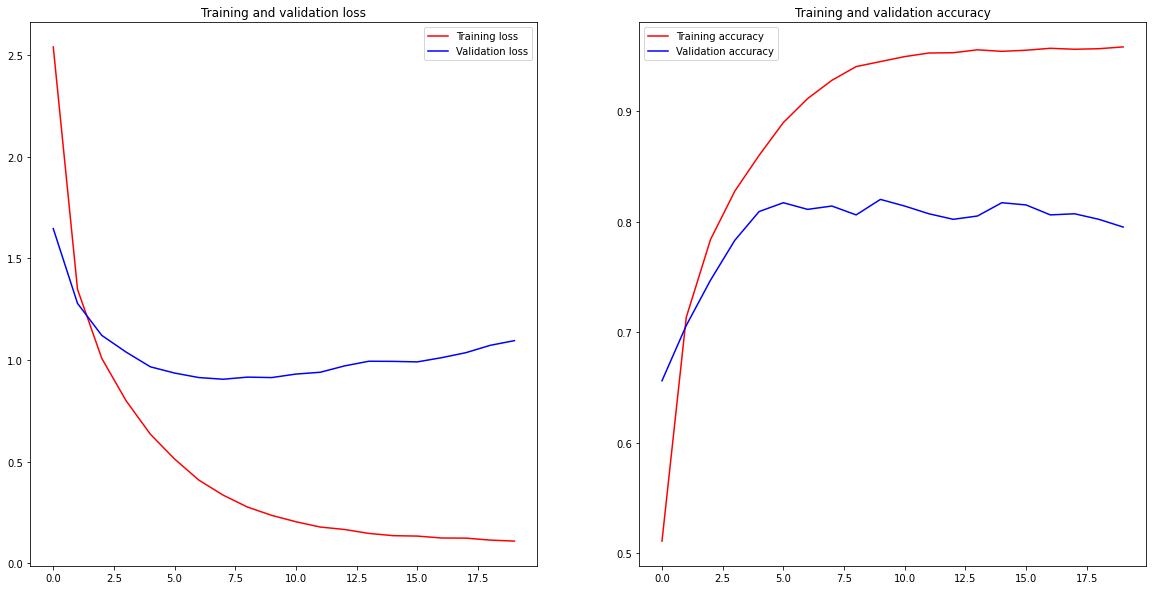

In [22]:
# 위를 보면 훈련시 손실-정확도 값과 검증시 손실-정확도 값이 저장되어 있는 것을 알 수 있다.
# 이를 이용해 훈련과 검증 손실 그래프를 그려보자
import matplotlib.pyplot as plt

history = history.history

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training accuracy')
axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
axs[1].set_title('Training and validation accuracy')
axs[1].legend(loc=0)

그래프를 확인해보면 대락 9~10번째부터 overfitting 이 생기는 것으로 보인다. 따라서 10번의 epochs으로 새로운 모델을 훈련하고 test data로 평가해보겠다.

In [23]:
model = keras.Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=46, activation='softmax')
])

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics='acc')

model.fit(x_train, y_train, epochs=10, batch_size=512)
model.evaluate(x_test, y_test)

Epoch 1/10
18/18 [==============================] - 2s 80ms/step - loss: 2.5511 - acc: 0.5357
Epoch 2/10
18/18 [==============================] - 1s 65ms/step - loss: 1.3526 - acc: 0.7194
Epoch 3/10
18/18 [==============================] - 1s 58ms/step - loss: 1.0111 - acc: 0.7831
Epoch 4/10
18/18 [==============================] - 1s 59ms/step - loss: 0.7928 - acc: 0.8328
Epoch 5/10
18/18 [==============================] - 1s 58ms/step - loss: 0.6302 - acc: 0.8661
Epoch 6/10
18/18 [==============================] - 1s 60ms/step - loss: 0.4991 - acc: 0.8951
Epoch 7/10
18/18 [==============================] - 1s 79ms/step - loss: 0.3992 - acc: 0.9153
Epoch 8/10
18/18 [==============================] - 1s 68ms/step - loss: 0.3273 - acc: 0.9287
Epoch 9/10
18/18 [==============================] - 1s 59ms/step - loss: 0.2771 - acc: 0.9380
Epoch 10/10
71/71 [==============================] - 1s 5ms/step - loss: 0.9976 - acc: 0.7881


[0.9976257681846619, 0.7880676984786987]

위는 모델은 80% 를 넘는 정확도를 달성했다. 만약 랜덤한 분류기를 사용하여 예측하면 정확도가 얼마나 나올까?

In [24]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.18699910952804988

새로운 데이터에 대해 예측해보자<br>
새로운 샘플로 모델의 predict 메서드를 호출하면 각 샘플에 대해 46개 토픽에 대한 클래스 확률 분포를 반환한다

In [25]:
# predictions 의 각 항목은 길이가 46인 벡터이다.
predictions = model.predict(x_test)
print('predictions : \n', predictions)
print()
print('predictions[0] : \n', predictions[0])
print()
print('predictions[0].shape : ', predictions[0].shape)

71/71 [==============================] - 0s 4ms/step
predictions : 
 [[3.33822595e-06 2.34818363e-05 2.75204929e-05 ... 1.99665756e-05
  7.16076329e-06 3.86492218e-07]
 [2.18177549e-04 2.44141463e-03 7.53046107e-03 ... 2.24622022e-06
  1.98009346e-07 5.61253910e-06]
 [1.77367276e-03 7.41418540e-01 1.91210513e-03 ... 6.46153348e-04
  1.26013372e-04 3.38502647e-03]
 ...
 [3.69458439e-06 9.33250485e-05 2.08032270e-05 ... 1.12380185e-05
  5.83773763e-05 3.06723564e-06]
 [2.85329530e-04 2.30373256e-02 6.85906562e-04 ... 7.88111356e-04
  3.03911773e-04 1.13490023e-04]
 [3.60666570e-04 2.37702549e-01 1.28463823e-02 ... 9.08831076e-04
  1.98686874e-04 1.36535952e-03]]

predictions[0] : 
 [3.3382260e-06 2.3481836e-05 2.7520493e-05 9.3103659e-01 6.4348854e-02
 1.5845553e-05 6.8327019e-05 1.5986441e-05 3.3198239e-04 3.0283229e-05
 1.3203521e-05 2.8628018e-04 9.4237466e-06 1.4413768e-04 3.5331723e-05
 3.6054803e-07 1.2644224e-03 3.6233701e-05 1.7026308e-05 4.0340052e-05
 6.0649659e-04 3.4018620e-0

In [26]:
# 이 벡터는 확률 분포를 나타내기 때문에 원소를 모두 더하면 1이 된다
np.sum(predictions[0])

1.0000001

In [27]:
# 가장 값이 큰것이 예측 클래스가 된다. 가장 확률이 높은 클래스를 확인하자
np.argmax(predictions[0])

3

레이블과 손실을 다루는 다른 방법<br>
앞서 언급한 것처럼 레이블을 인코딩하는 것 말고 다른 방법은 다음과 같이 정수 텐서로 변환하는 것이다.
```python
y_train = np.array(train_labels)
y_test = np.array(test_labels)
```
이 방식을 사용하려면 손실 함수 하나만 바꾸면 된다. 앞서 사용된 `categorical_crossentropy`는 레이블이 범주형 인코딩이 되어있을 때 사용하는 것이고, 정수 레이블을 사용할 때에는 `spars_categorical_crossentropy` 를 이용해야 한다.<br><br>
둘은 인터페이스만 다르고 수학적으로 동일하다

### 충분히 큰 중간층(Dense)을(를) 두어야 하는 이유
앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층(Dense)의 유닛이 46개보다 적어서는 안된다. 많아야 좋다. <br>
만약 작은 중간층을 두면 정보의 병목이 어떻게 생기는 지 확인해보자

In [28]:
# 정보의 병복이 있는 모델
model = keras.Sequential([
    Dense(64, activation='relu'),
    # 4차원으로 유닛 줄이기
    Dense(4, activation='relu'),
    Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='acc')
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 22ms/step - loss: 3.0120 - acc: 0.3291 - val_loss: 2.2093 - val_acc: 0.5060
Epoch 2/20
63/63 [==============================] - 1s 20ms/step - loss: 1.8231 - acc: 0.6009 - val_loss: 1.6420 - val_acc: 0.6300
Epoch 3/20
63/63 [==============================] - 2s 33ms/step - loss: 1.4737 - acc: 0.6481 - val_loss: 1.5184 - val_acc: 0.6450
Epoch 4/20
63/63 [==============================] - 2s 33ms/step - loss: 1.3159 - acc: 0.6665 - val_loss: 1.4652 - val_acc: 0.6530
Epoch 5/20
63/63 [==============================] - 1s 23ms/step - loss: 1.2108 - acc: 0.6962 - val_loss: 1.4379 - val_acc: 0.6630
Epoch 6/20
63/63 [==============================] - 1s 23ms/step - loss: 1.1280 - acc: 0.7134 - val_loss: 1.4122 - val_acc: 0.6720
Epoch 7/20
63/63 [==============================] - 1s 22ms/step - loss: 1.0546 - acc: 0.7175 - val_loss: 1.4168 - val_acc: 0.6700
Epoch 8/20
63/63 [==============================] - 1s 20ms/step - loss: 0.9887 - a

위에 정확도가 80%대가 나왔던 것에 비해 이번에는 71% 대로 약 8% 감소한 것을 확인 할 수 있었다. 이런 손실의 원인 대부분은 많은 정보(클래스 46개의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문이다. 이 모델은 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 당연히.. 전부 넣지 못하기 때문에 정확도가 줄어들 수 밖에 없다.